# Main For Part 3

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
# Needed for training
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, DataLoader
from torch.utils.data.dataset import Subset
# Models
from models_part1 import FinalClassifier
from models_part3 import NTXentLoss,MnistSimCLR,Cifar10SimCLR
from models_testing import  plot_accuracies,plot_losses,test_classifier,test_classifyingAutoEncoder
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# MNIST

# Preparing Data

In [85]:
mnist_path = "./mnist_data"

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(
    root=mnist_path,  
    train=True,       
    transform=train_transform,  # Apply train transformations
    download=True     
)

test_dataset = torchvision.datasets.MNIST(
    root=mnist_path,
    train=False,  
    transform=test_transform,  # Apply test transformations
    download=True
)

print("MNIST dataset downloaded successfully!")

MNIST dataset downloaded successfully!


In [86]:
train_size = 50_000
val_size = 10_000
batch_size = 256


train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

# Create DataLoaders
mnist_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
mnist_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
mnist_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

# images, labels = next(iter(mnist_train_loader))
# print(f"Batch shape: {images.shape}, Labels: {labels[:5]}")

Train size: 50000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!


# Experiment

In [87]:
model = MnistSimCLR(latent_dim=128,dropout_prob=0.1,temperature = 0.1).to(device)
train_losses,val_losses = model.train_autoencoder(train_loader= mnist_train_loader,
                       val_loader=mnist_val_loader,
                       num_epochs=40,
                       learning_rate=1e-3,
                       weight_decay= 1e-3)


Epoch [1/40], Time: 5.36s, Train Loss: 4.8673, Val Loss: 2.2847, LR: 0.001000
Epoch [2/40], Time: 5.61s, Train Loss: 3.2655, Val Loss: 1.4177, LR: 0.001000
Epoch [3/40], Time: 5.35s, Train Loss: 2.5975, Val Loss: 1.1198, LR: 0.001000
Epoch [4/40], Time: 5.45s, Train Loss: 2.2668, Val Loss: 0.8862, LR: 0.001000
Epoch [5/40], Time: 5.36s, Train Loss: 1.9469, Val Loss: 0.8013, LR: 0.001000
Epoch [6/40], Time: 5.40s, Train Loss: 1.8590, Val Loss: 0.7737, LR: 0.001000
Epoch [7/40], Time: 5.35s, Train Loss: 1.7897, Val Loss: 0.7121, LR: 0.001000
Epoch [8/40], Time: 5.37s, Train Loss: 1.6562, Val Loss: 0.5713, LR: 0.001000
Epoch [9/40], Time: 5.65s, Train Loss: 1.5270, Val Loss: 0.6333, LR: 0.001000
Epoch [10/40], Time: 6.08s, Train Loss: 1.4065, Val Loss: 0.5000, LR: 0.001000
Epoch [11/40], Time: 5.64s, Train Loss: 1.3374, Val Loss: 0.4989, LR: 0.001000
Epoch [12/40], Time: 5.71s, Train Loss: 1.2755, Val Loss: 0.4556, LR: 0.001000
Epoch [13/40], Time: 5.85s, Train Loss: 1.2605, Val Loss: 0.3

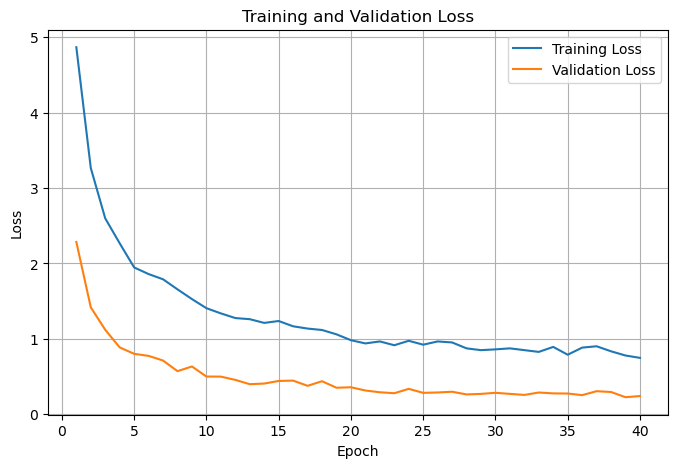

In [88]:
plot_losses(train_losses = train_losses, val_losses = val_losses)

In [89]:
pretrained_encoder = model.encoder
for param in pretrained_encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen
classifier = FinalClassifier(latent_dim=128)
train_losses, train_accuracies, val_accuracies = classifier.fit_classifier(encoder = pretrained_encoder,
                                                                           train_loader =  mnist_train_loader,
                                                                           val_loader = mnist_val_loader,
                                                                           num_epochs=30, 
                                                                           learning_rate=1e-4)


Epoch [1/30], Time: 8.77s, Train Loss: 0.6606, Train Accuracy: 82.99%, Val Accuracy: 92.79%, LR: 0.000100
Epoch [2/30], Time: 8.59s, Train Loss: 0.2781, Train Accuracy: 93.04%, Val Accuracy: 94.98%, LR: 0.000100
Epoch [3/30], Time: 8.46s, Train Loss: 0.2015, Train Accuracy: 94.68%, Val Accuracy: 95.74%, LR: 0.000100
Epoch [4/30], Time: 8.67s, Train Loss: 0.1623, Train Accuracy: 95.45%, Val Accuracy: 96.41%, LR: 0.000100
Epoch [5/30], Time: 8.75s, Train Loss: 0.1359, Train Accuracy: 96.15%, Val Accuracy: 96.79%, LR: 0.000100
Epoch [6/30], Time: 8.92s, Train Loss: 0.1200, Train Accuracy: 96.53%, Val Accuracy: 97.02%, LR: 0.000100
Epoch [7/30], Time: 9.15s, Train Loss: 0.1063, Train Accuracy: 96.94%, Val Accuracy: 97.33%, LR: 0.000100
Epoch [8/30], Time: 8.93s, Train Loss: 0.0965, Train Accuracy: 97.05%, Val Accuracy: 97.48%, LR: 0.000100
Epoch [9/30], Time: 8.83s, Train Loss: 0.0897, Train Accuracy: 97.33%, Val Accuracy: 97.76%, LR: 0.000100
Epoch [10/30], Time: 9.23s, Train Loss: 0.0819

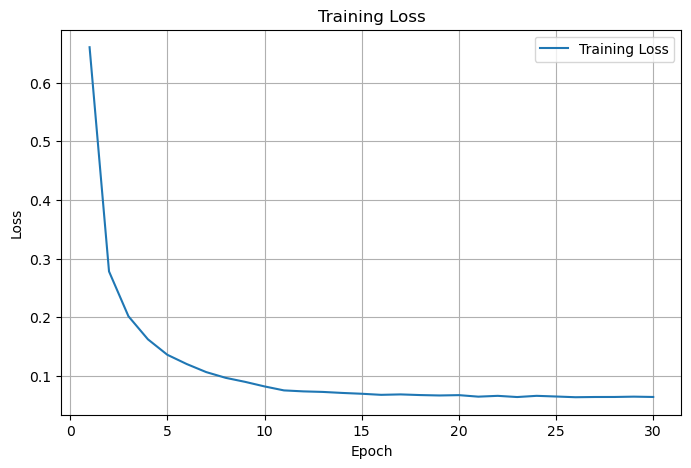

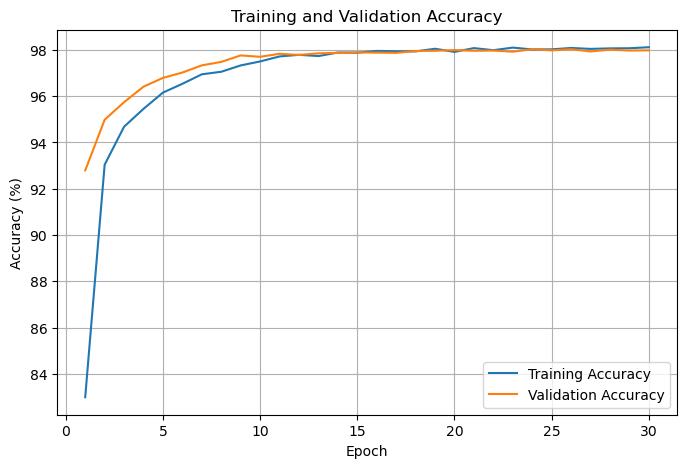

In [90]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [91]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=mnist_test_loader)

Test Accuracy: 97.93%


# Cifar10

# Preparing data

In [76]:
cifar10_path = "./cifar10_data"

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

c10_full_train_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,  
    train=True,       
    transform=train_transform,
    download=True     
)

c10_test_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,
    train=False,  
    transform=test_transform,
    download=True
)

print("CIFAR-10 dataset downloaded successfully!")

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 dataset downloaded successfully!


In [77]:
train_size = 40_000
val_size = 10_000
batch_size = 256

c10_train_dataset, c10_val_dataset = random_split(c10_full_train_dataset, [train_size, val_size])

# Check dataset sizes
print(f"Train size: {len(c10_train_dataset)}, Validation size: {len(c10_val_dataset)}, Test size: {len(c10_test_dataset)}")



# Create DataLoaders
c10_train_loader = DataLoader(c10_train_dataset, batch_size=batch_size, shuffle=True)
c10_val_loader = DataLoader(c10_val_dataset, batch_size=batch_size, shuffle=False)
c10_test_loader = DataLoader(c10_test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

# Get a batch of images and labels from the train_loader
images, labels = next(iter(c10_train_loader))
print(f"Batch shape: {images.shape}, Labels (first 5): {labels[:5]}")

Train size: 40000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!
Batch shape: torch.Size([256, 3, 32, 32]), Labels (first 5): tensor([1, 3, 8, 5, 7])


# Experiment

In [78]:
model = Cifar10SimCLR(latent_dim=128,
                      dropout_prob=0.1,
                      temperature=0.1).to(device)
train_losses,val_losses = model.train_autoencoder(train_loader = c10_train_loader,
                        val_loader = c10_val_loader,
                        num_epochs=40,
                        learning_rate=1e-3,
                        weight_decay= 1e-3)

Initializing weights ....
Initializing weights DONE
Epoch [1/40], Time: 8.90s, Train Loss: 2.4944, Val Loss: 0.4619, LR: 0.001000
Epoch [2/40], Time: 8.70s, Train Loss: 1.6803, Val Loss: 0.3134, LR: 0.001000
Epoch [3/40], Time: 8.65s, Train Loss: 1.3258, Val Loss: 0.2562, LR: 0.001000
Epoch [4/40], Time: 9.10s, Train Loss: 1.1514, Val Loss: 0.1907, LR: 0.001000
Epoch [5/40], Time: 9.03s, Train Loss: 1.0517, Val Loss: 0.1702, LR: 0.001000
Epoch [6/40], Time: 8.90s, Train Loss: 1.0196, Val Loss: 0.1873, LR: 0.001000
Epoch [7/40], Time: 8.74s, Train Loss: 0.8827, Val Loss: 0.1477, LR: 0.001000
Epoch [8/40], Time: 8.67s, Train Loss: 0.8266, Val Loss: 0.1419, LR: 0.001000
Epoch [9/40], Time: 9.33s, Train Loss: 0.7808, Val Loss: 0.1328, LR: 0.001000
Epoch [10/40], Time: 9.09s, Train Loss: 0.6466, Val Loss: 0.1261, LR: 0.001000
Epoch [11/40], Time: 8.98s, Train Loss: 0.7741, Val Loss: 0.1786, LR: 0.001000
Epoch [12/40], Time: 9.07s, Train Loss: 0.6437, Val Loss: 0.1325, LR: 0.001000
Epoch [13

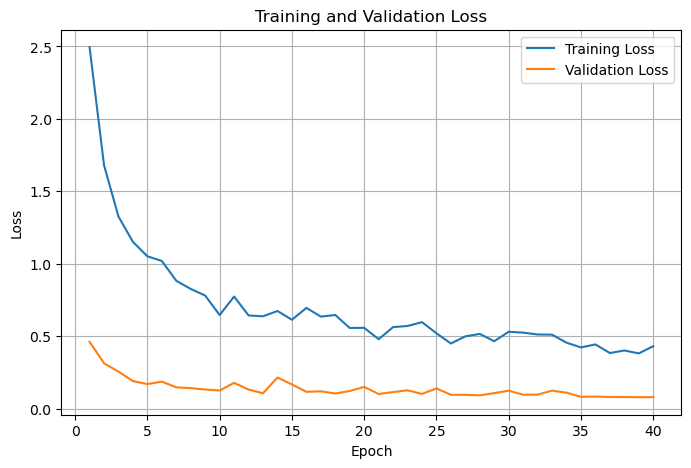

In [79]:
plot_losses(train_losses = train_losses, val_losses = val_losses)

In [80]:
for param in model.encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen
pretrained_encoder = model.encoder
classifier = FinalClassifier(latent_dim=128)
train_losses, train_accuracies, val_accuracies = classifier.fit_classifier(encoder = pretrained_encoder,
                                                                           train_loader =  c10_train_loader,
                                                                           val_loader = c10_val_loader,
                                                                           num_epochs=30, 
                                                                           learning_rate=1e-3)

Epoch [1/30], Time: 10.61s, Train Loss: 1.3438, Train Accuracy: 52.81%, Val Accuracy: 58.94%, LR: 0.001000
Epoch [2/30], Time: 10.61s, Train Loss: 1.1722, Train Accuracy: 58.41%, Val Accuracy: 61.19%, LR: 0.001000
Epoch [3/30], Time: 10.51s, Train Loss: 1.1190, Train Accuracy: 60.48%, Val Accuracy: 61.93%, LR: 0.001000
Epoch [4/30], Time: 10.49s, Train Loss: 1.0822, Train Accuracy: 61.78%, Val Accuracy: 62.42%, LR: 0.001000
Epoch [5/30], Time: 10.48s, Train Loss: 1.0546, Train Accuracy: 62.96%, Val Accuracy: 62.60%, LR: 0.001000
Epoch [6/30], Time: 10.50s, Train Loss: 1.0314, Train Accuracy: 63.67%, Val Accuracy: 63.52%, LR: 0.001000
Epoch [7/30], Time: 10.57s, Train Loss: 1.0095, Train Accuracy: 64.13%, Val Accuracy: 64.32%, LR: 0.001000
Epoch [8/30], Time: 10.41s, Train Loss: 0.9963, Train Accuracy: 64.81%, Val Accuracy: 63.62%, LR: 0.001000
Epoch [9/30], Time: 10.46s, Train Loss: 0.9778, Train Accuracy: 65.52%, Val Accuracy: 64.22%, LR: 0.001000
Epoch [10/30], Time: 10.49s, Train Lo

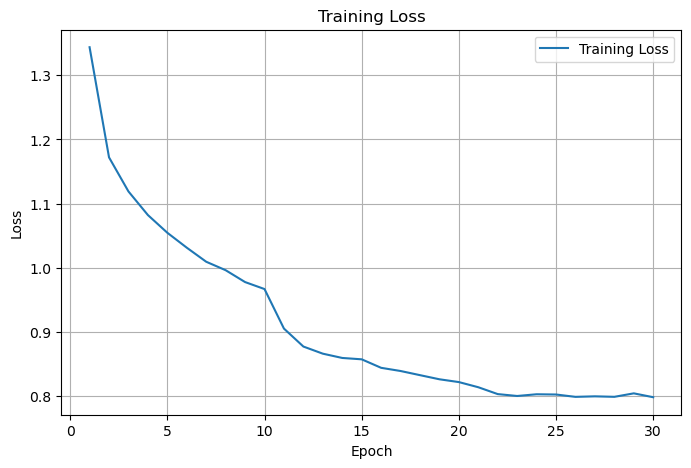

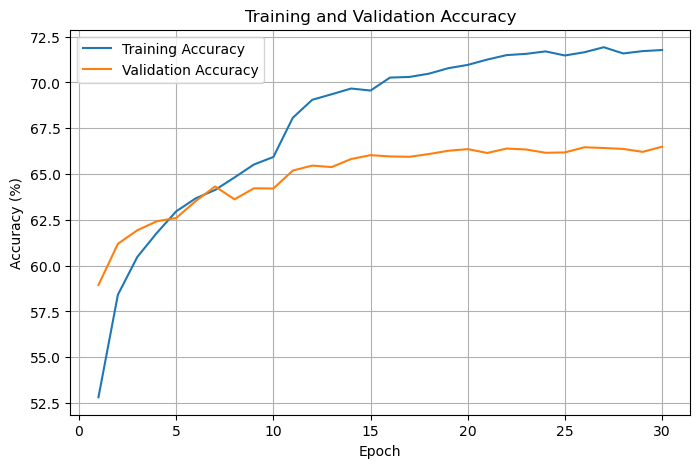

In [81]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [82]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=c10_test_loader)

Test Accuracy: 66.32%
